**Generation of a dataset already splited into train, val and test to standarize the evaluation of the different approaches for NER on clinical trial eligibility criteria**

In this case, we are not going to consider pregnancy consideration classes, as well as mood entity.

In [42]:
import numpy as np 
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login

In [43]:
# paths
root = '..'
# root = './drive/MyDrive/ProjectName' # if you are using google drive
data_path = f'{root}/data'
chia_bio = f'{data_path}/chia/'

In [44]:
# read all the sentences per file
files_train = os.listdir(f'{data_path}/chia/trains')
files_test = os.listdir(f'{data_path}/chia/tests')

In [45]:
len(files_train), len(files_test)

(1800, 200)

In [104]:
# dict for the entities (entity to int value)
simple_ent = {"Condition", "Value", "Drug", "Procedure", "Measurement", "Temporal", "Observation", "Person", "Device"}
sel_ent = {
    "O": 0,
    "B-Condition": 1,
    "I-Condition": 2,
    "B-Value": 3,
    "I-Value": 4,
    "B-Drug": 5,
    "I-Drug": 6,
    "B-Procedure": 7,
    "I-Procedure": 8,
    "B-Measurement": 9,
    "I-Measurement": 10,
    "B-Temporal": 11,
    "I-Temporal": 12,
    "B-Observation": 13,
    "I-Observation": 14,
    "B-Person": 15,
    "I-Person": 16,
    "B-Device": 17,
    "I-Device": 18
}

entities_list = list(sel_ent.keys())
sel_ent_inv = {v: k for k, v in sel_ent.items()}

In [47]:
def read_file(file_path):
    """
    Read the file and return a list of sentences with annotations
    inputs: file_path: str
    outputs: list of sentences with annotations
    """
    ann_file = []
    with open(file_path, "r") as fd:
        sentences_ann = fd.read().split("\n\n")
    sentences_ann = [sentence for sentence in sentences_ann if sentence != "" and sentence != '\n']

    for i in range(len(sentences_ann)):
        annotation = []
        lines = sentences_ann[i].split("\n")
        for line in lines:
            if line != "":
                spt_line = line.split()
                label = spt_line[-1]
                if label not in sel_ent:
                    label = 'O'
                annotation.append((spt_line[0], label))
        new_annotation = []
        ps = r'(\.|\,|\:|\;|\!|\?|\-|\(|\)|\[|\]|\{|\}|\")'
        for i,(word, tag) in enumerate(annotation):
            if re.search(ps, word):
                # find the ocurrences of the punctuation signs
                occurrences = re.finditer(ps, word)
                indexes = [(match.start(), match.end()) for match in occurrences]
                # create the new tokens
                last = 0
                for j, (beg, end) in enumerate(indexes):
                    if beg > last:
                        new_annotation.append((word[last:beg], tag))
                    if tag != "O":
                        label = f'I-{tag.split("-")[1]}'
                    else:
                        label = "O"
                    if end < len(word) or (i < len(annotation) - 1 and annotation[i+1][1] == label):
                        new_annotation.append((word[beg:end], label))
                    else:
                        new_annotation.append((word[beg:end], 'O')) 
                    last = end
                if last < len(word):
                    new_annotation.append((word[last:], label))
            else:
                new_annotation.append((word, tag))
        ann_file.append(new_annotation)
    return ann_file

In [48]:
# read the training files
train_annotations = {}

for file in files_train:
    train_annotations[file] = read_file(f'{chia_bio}/trains/{file}')
print(f'Number of training files: {len(train_annotations)}')
print(f'Total number of sentences in training files: {sum([len(train_annotations[file]) for file in train_annotations])}')

Number of training files: 1800
Total number of sentences in training files: 11102


In [49]:
# read the testing files
test_annotations = {}

for file in files_test:
    test_annotations[file] = read_file(f'{chia_bio}/tests/{file}')
print(f'Number of testing files: {len(test_annotations)}')
print(f'Total number of sentences in testing files: {sum([len(test_annotations[file]) for file in test_annotations])}')

Number of testing files: 200
Total number of sentences in testing files: 1307


In [50]:
def build_df(annotations):
    """
    Build a dataframe with the sentences and annotations
    inputs: annotations: dict
    outputs: dataframe
    """
    annotations_df = []
    for file in annotations:
        for i in range(len(annotations[file])):
            dict_sent = {"tokens": [], "ner_tags": [], "file": file, "index": i}
            for word, tag in annotations[file][i]:
                dict_sent["tokens"].append(word)
                # add the int representation of the entity
                dict_sent["ner_tags"].append(sel_ent[tag])
            annotations_df.append(dict_sent)
    return pd.DataFrame(annotations_df)

In [51]:
# build the dataframes
train_df = build_df(train_annotations)
test_df = build_df(test_annotations)

In [54]:
train_df.head()

,tokens,ner_tags,file,index
0,"[Patients, refuse, to, follow, the, research]","[0, 13, 14, 14, 14, 14]",NCT03134378_exc.bio.txt,0
1,"[Patient, has, had, previous, eradication, the...","[0, 0, 0, 11, 7, 8, 0, 1, 2, 2, 0]",NCT03134378_exc.bio.txt,1
2,"[The, patient, is, pregnant, or, breastfeeding]","[0, 0, 0, 1, 0, 13]",NCT03134378_exc.bio.txt,2
3,"[Patients, have, a, history, of, allergy, to, ...","[0, 0, 0, 13, 0, 1, 0, 0, 5, 6, 6, 6, 6, 0, 5,...",NCT03134378_exc.bio.txt,3
4,"[Patients, are, known, to, have, impaired, liv...","[0, 0, 0, 0, 0, 3, 9, 10, 0, 0, 0, 9, 10, 3, 4...",NCT03134378_exc.bio.txt,4


In [56]:
# split the training data into training and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [120]:
train_df.columns, val_df.columns, test_df.columns

(Index(['tokens', 'ner_tags', 'file', 'index'], dtype='object'),
 Index(['tokens', 'ner_tags', 'file', 'index'], dtype='object'),
 Index(['tokens', 'ner_tags', 'file', 'index'], dtype='object'))

In [127]:
# create dataset instance
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [128]:
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])

In [129]:
# create the dataset with all the data splited in train, validation and test
dataset = DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
})

In [130]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'file', 'index'],
        num_rows: 8881
    })
    val: Dataset({
        features: ['tokens', 'ner_tags', 'file', 'index'],
        num_rows: 2221
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'file', 'index'],
        num_rows: 1307
    })
})

**Analysis of entities distribution on the dataset**

In [97]:
all_entities_tr = [ent for ents in train_df.ner_tags for ent in ents]
all_entities_val = [ent for ents in val_df.ner_tags for ent in ents]
all_entities_test = [ent for ents in test_df.ner_tags for ent in ents]

In [98]:
# get just the main entity (not B- or I-)
all_entities_tr = [entities_list[ent][2:] for ent in all_entities_tr if entities_list[ent].startswith('B-')]
all_entities_val = [entities_list[ent][2:] for ent in all_entities_val if entities_list[ent].startswith('B-')]
all_entities_test = [entities_list[ent][2:] for ent in all_entities_test if entities_list[ent].startswith('B-')]

{'Condition': 8031, 'Procedure': 2285, 'Person': 1136, 'Device': 264, 'Value': 2677, 'Drug': 2479, 'Temporal': 2129, 'Measurement': 2292, 'Observation': 1171}
train dict_values([8031, 2285, 1136, 264, 2677, 2479, 2129, 2292, 1171])
{'Condition': 1913, 'Procedure': 602, 'Person': 257, 'Device': 59, 'Value': 628, 'Drug': 593, 'Temporal': 510, 'Measurement': 534, 'Observation': 328}
val dict_values([1913, 602, 257, 59, 628, 593, 510, 534, 328])
{'Condition': 1104, 'Procedure': 311, 'Person': 135, 'Device': 23, 'Value': 345, 'Drug': 443, 'Temporal': 295, 'Measurement': 288, 'Observation': 166}
test dict_values([1104, 311, 135, 23, 345, 443, 295, 288, 166])


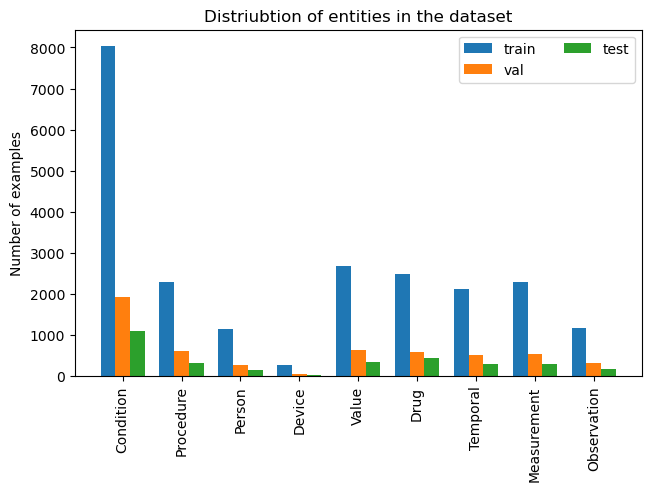

In [105]:
# plot the relations
x = np.arange(len(simple_ent))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

entities_dict = {
    'train': all_entities_tr,
    'val': all_entities_val,
    'test': all_entities_test
}

for l in ['train', 'val', 'test']:
    offset = width * multiplier
    dict_ent = {ent: entities_dict[l].count(ent) for ent in simple_ent}
    print(dict_ent)
    v = dict_ent.values()
    print(l, v)
    rects = ax.bar(x + offset, v, width, label=l)
    multiplier += 1

ax.set_ylabel('Number of examples')
ax.set_title('Distriubtion of entities in the dataset')
ax.set_xticks(x + width, simple_ent)
ax.legend(loc='upper right', ncols=2)

plt.xticks(rotation=90)
plt.show()

**Save dataset in huggingface**

In [137]:
notebook_login()

In [138]:
dataset.push_to_hub('JavierLopetegui/chia_v1')

Pushing split train to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
Pushing split val to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
Pushing split test to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
